In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300
# we want to use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from models.vae import VAE
from models.mdrnn import MDRNN

def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

# parameters
batch_size = 128
learning_rate = 1e-4
num_epochs = 50

c:\Users\fphub\mambaforge\envs\deep_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# import data from the moving mnist dataset
data_sequential = np.load('data/bouncing_mnist_test.npy')
data_sequential = data_sequential / 255
data = data_sequential.reshape((200000,1,64,64)) # we split the 10000 video of 20 frames into 200000 images of 64x64 pixels

# the data is shuffled when loaded
train_loader_sequential = torch.utils.data.DataLoader(
                 dataset=data_sequential,
                 batch_size=batch_size,
                 shuffle=True)

# the data is shuffled when loaded
train_loader = torch.utils.data.DataLoader(
                 dataset=data,
                 batch_size=batch_size,
                 shuffle=True)

### Train the VAE module

In [95]:
V_model = VAE(img_channels=1, latent_size=32, beta = 1).to(device)
print('nb of params : {}'.format(count_parameters(V_model)))

nb of params : 1862273


In [96]:
# optimizer
optimizer = torch.optim.Adam(V_model.parameters(), lr=learning_rate)

In [100]:
for epoch in range(num_epochs):

    pbar = tqdm(train_loader)
    pbar.set_description("epoch %s/ loss=? " % str(epoch+1))
    
    for data in pbar:
        
        imgs = data
        imgs = imgs.to(device).float()
        
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logsigma = V_model(imgs)

        loss,loss_KL = V_model.loss_function(out, imgs, mu, logsigma)
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description("epoch "+str(epoch+1)+"/"+str(num_epochs)+" loss= "+str(loss.cpu().detach().numpy())+" loss KL = "+str(loss_KL.cpu().detach().numpy()))

epoch 1/50 loss= 28380.988 loss KL = 4768.0615:  30%|███       | 476/1563 [00:20<00:47, 22.98it/s]


KeyboardInterrupt: 

c:\Users\fphub\mambaforge\envs\deep_env\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


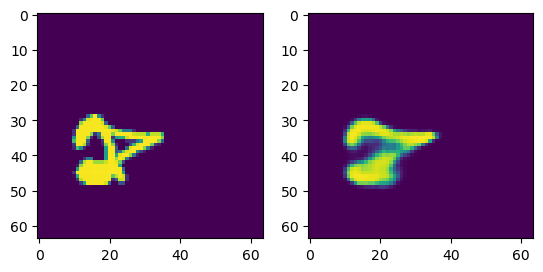

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import random

with torch.no_grad():
    for data in random.sample(list(train_loader), 1):
        imgs = data
        imgs = imgs.to(device).float()
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logsigma = V_model(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))

In [88]:
# save V model
torch.save(V_model.state_dict(), 'saved_models/vae-mdrnn/vae_moving_digits_2802.pt')

In [99]:
# load V model
V_model = VAE(img_channels=1, latent_size=32).to(device)
V_model.load_state_dict(torch.load('saved_models/vae-mdrnn/vae_moving_digits_2802.pt'))

<All keys matched successfully>

### Training the RNN-MDN module

In [58]:
# parameters
batch_size = 64
learning_rate = 1e-4
num_epochs = 50

In [59]:
M_model = MDRNN(latents=32, actions=2, hiddens=128, gaussians=1).to(device)

In [60]:
M_optimizer = torch.optim.Adam(M_model.parameters(), lr=learning_rate)
count_parameters(M_model)

29377

In [70]:

for epoch in range(50):
    pbar = tqdm(train_loader_sequential)
    pbar.set_description("epoch %s/ loss=? " % str(epoch+1))
    for x in pbar:
        x = torch.reshape(x,(-1,1,64,64)).float().to(device)
        latents = V_model.encoder(x)[0]
        # x = torch.transpose(torch.reshape(x,(-1,20,64,64)),0,1).float().to(device)
        latents = torch.transpose(torch.reshape(latents,(-1,20,32)),0,1)
        seq_len, batch_size,_ = latents.shape

        if M_model.memory == 'rnn':
            hidden = torch.zeros(batch_size, M_model.hiddens).to(device)
        else :
            hidden = (torch.zeros(batch_size, M_model.hiddens).to(device), torch.zeros(batch_size, M_model.hiddens).to(device))
        action = torch.zeros(batch_size, 2).to(device)

        M_optimizer.zero_grad()
        episode_loss = []
        for t in range(seq_len-1):
            
            latent = latents[t,:,:]
            latent_next_obs = latents[t+1,:,:]

            if M_model.memory == 'rnn':
                mus, sigmas, logpi, next_hidden = M_model(action,latent,hidden)
                hidden = next_hidden[1].squeeze(0)
            else :
                mus, sigmas, logpi, next_hidden = M_model(action,latent,hidden)
                hidden = next_hidden

            loss = M_model.loss_function(mus, sigmas, logpi,latent_next_obs)
            episode_loss.append(loss)

        episode_loss = torch.stack(episode_loss).sum()
        episode_loss.backward()
        M_optimizer.step()

        pbar.set_description("epoch "+str(epoch+1)+"/"+str(num_epochs)+"  loss= "+str(loss.cpu().detach().numpy()) )

epoch 6/50  loss= 8.004192:  43%|████▎     | 34/79 [00:14<00:19,  2.35it/s] 


KeyboardInterrupt: 

In [71]:
# save V model
torch.save(M_model.state_dict(), 'saved_models/vae-mdrnn/mdrnn_moving_digits_2802.pt')

In [20]:
# load V model
M_model =  MDRNN(latents=32, actions=2, hiddens=128, gaussians=1).to(device)
M_model.load_state_dict(torch.load('saved_models/vae-mdrnn/mdrnn_moving_digits_2802.pt'))

<All keys matched successfully>

In [72]:
# test the reconstruction
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100

def plot_video_comparison(video,reconstructed_video):
    fig,ax = plt.subplots(2,20,figsize=(20,2))
    for i in range(video.shape[0]):
        ax[0,i].imshow(video[i,:,:])
        ax[0,i].axis('off')
    for i in range(video.shape[0]):
        ax[1,i].imshow(reconstructed_video[i,:,:])
        ax[1,i].axis('off')
    fig.tight_layout()

def run_vae_prediction(video):
    batch_size,seq_len,_,_ = video.shape
    video_tensor = torch.reshape(torch.tensor(video).float(),(-1,1,64,64)).float().to(device)
    reconstructed_video,latent_video, _  = V_model(video_tensor)
    reconstructed_video = torch.reshape(reconstructed_video,(batch_size,seq_len,64,64))
    latent_video = torch.reshape(latent_video,(batch_size,seq_len,32))
    return reconstructed_video.cpu().detach().numpy(),latent_video.cpu().detach().numpy()

def run_model_prediction(video):
    video = np.transpose(video,(1,0,2,3))
    seq_len,batch_size,_,_ = video.shape
    video_tensor = torch.reshape(torch.tensor(video).float(),(-1,1,64,64)).float().to(device)
    reconstructed_video,latent_video, latent_video_variance  = V_model(video_tensor)
    
    latent_video = torch.reshape(latent_video,(seq_len,batch_size,32))
    latent_video_variance = torch.reshape(latent_video_variance,(seq_len,batch_size,32))
    reconstructed_video = torch.reshape(reconstructed_video,(seq_len,batch_size,64,64))

    if M_model.memory == 'rnn':
        hidden = torch.zeros(batch_size, M_model.hiddens).to(device)
    else :
        hidden = (torch.zeros(batch_size, M_model.hiddens).to(device),
                        torch.zeros(batch_size, M_model.hiddens).to(device))
    action = torch.zeros(batch_size, 2).to(device)

    mean_pred = []
    sig_pred = []
    for t in range(seq_len):

        latent = latent_video[t,:,:]

        if M_model.memory == 'rnn':
            mus, sigmas, logpi, next_hidden = M_model(action,latent,hidden)
            hidden = next_hidden[1].squeeze(0)
        else :
            mus, sigmas, logpi, next_hidden = M_model(action,latent,hidden)
            hidden = next_hidden

        mean_pred.append(mus[:,0,:].cpu().detach().numpy())
        sig_pred.append(sigmas[:,0,:].cpu().detach().numpy())

    mean_pred = np.array(mean_pred).transpose(1,0,2)
    sig_pred = np.array(sig_pred).transpose(1,0,2)
    latent_video = latent_video.cpu().detach().numpy().transpose(1,0,2)
    latent_video_variance = np.exp(latent_video_variance.cpu().detach().numpy()).transpose(1,0,2)
    reconstructed_video = reconstructed_video.cpu().detach().numpy().transpose(1,0,2,3)
    
    return reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred



(100, 20, 64, 64)


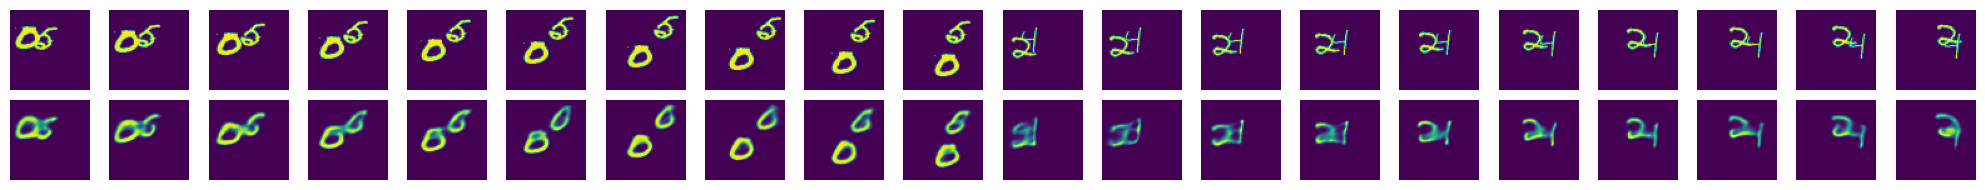

In [85]:
random_index_1 = np.random.randint(10000,size=100)
random_index_2 = np.random.randint(10000,size=100)
video = data_sequential[random_index_1,:]
video = np.concatenate((data_sequential[random_index_1,:10],data_sequential[random_index_2,:10]),axis=1) 
print(video.shape)
# sample = np.concatenate((data_sequential[random_index_1][:10],data_sequential[random_index_2+1][10:]))

reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred = run_model_prediction(video)
plot_video_comparison(video[0],reconstructed_video[0])

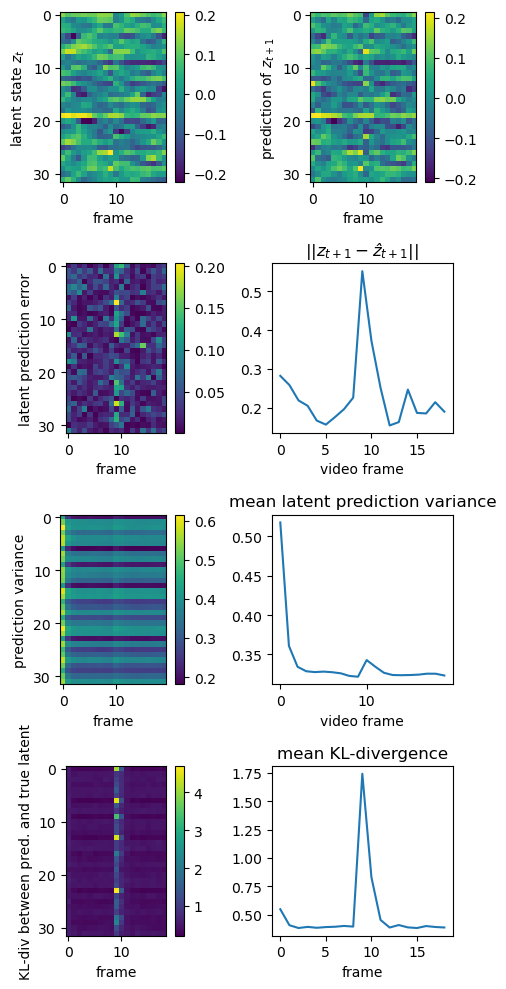

In [86]:
f = plt.figure(figsize=(5,10))

z = np.mean(latent_video,axis=0).T
z_pred = np.mean(mean_pred,axis=0).T
z_error = np.abs(z_pred[:,:-1] - z[:,1:])
z_error_norm = np.linalg.norm(z_error,axis=0)

z_pred_mean = mean_pred[:,:-1,:]
z_pred_var =sig_pred[:,:-1,:]
z_mean = latent_video[:,1:,:]
z_var =latent_video_variance[:,1:,:]
kl_loss = -0.5 * np.sum(np.expand_dims(z_var,-1) - np.expand_dims(z_pred_var,-1) - np.divide((np.expand_dims(z_var,-1) + (np.expand_dims(z_mean,-1) - np.expand_dims(z_pred_mean,-1))**2),np.expand_dims(z_pred_var,-1)+1e-10),axis=-1)

plt.subplot(421)
plt.imshow(z)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel(r'latent state $z_{t}$')

plt.subplot(422)
plt.imshow(z_pred)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel(r'prediction of $z_{t+1}$ ')

plt.subplot(423)
plt.imshow(z_error)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent prediction error')

plt.subplot(424)
plt.plot(z_error_norm)
plt.xlabel('video frame')
plt.title(r'$||z_{t+1} - ẑ_{t+1}||$')

plt.subplot(425)
plt.imshow(np.mean(sig_pred,axis=0).T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('prediction variance')

plt.subplot(426)
plt.plot(np.mean(np.mean(sig_pred,axis=0).T,axis=0))
plt.xlabel('video frame')
plt.title('mean latent prediction variance')

plt.subplot(427)
plt.imshow(np.mean(kl_loss,axis=0).T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('KL-div between pred. and true latent')

plt.subplot(428)
plt.plot(np.mean(np.mean(kl_loss,axis=0).T,axis=0))
plt.xlabel('frame')
plt.title('mean KL-divergence')

f.tight_layout()
plt.show()